## Preparing data

In [2]:
import xarray as xr
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from datetime import datetime, timedelta
from functools import partial
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
import numpy as np
import glob
import dask.array as da
import pandas as pd

In [3]:
start_time = "2019-01-01"
end_time = "2019-01-02"
year = 2014

parent_in_path = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/{year}global"
parent_in_path_b = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/{year-1}global"
parent_in_path_a = f"/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/{year+1}global"
data_paths = {
            "era5land": f"{parent_in_path}/era5land/*.nc",
            "lai": f"{parent_in_path}/lai_v2/*.nc",
            "ssm": f"{parent_in_path}/ssm/GlobalGSSM11km2014_20240214.tif",
            "co2": f"{parent_in_path}/co2/CAMS_CO2_2003-2020.nc",
            "landcover": f"{parent_in_path}/igbp/landcover10km_global.nc",
            "vcmax": f"{parent_in_path}/vcmax/TROPOMI_Vmax_Tg_mean10km_global.nc",
            "canopyheight": f"{parent_in_path}/canopy_height/canopy_height_11kmEurope20230921_10km.nc",
            }

parent_out_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah/"

In [4]:
# read shape file
eu_shape_file = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/1input_data/EuropeBoundary.shp"
gdf = gpd.read_file(eu_shape_file)
bbox = gdf.total_bounds
bbox

array([-31.28903052,  34.93055094,  68.93136141,  81.85192337])

In [5]:
def era5_preprocess(ds):    
    # Convert the longitude coordinates from [0, 360] to [-180, 180]
    ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180))
    return ds

def co2_preprocess(ds, start_time, end_time):    
    ds = ds.sel(time=slice(start_time, end_time))
    return ds

co2_partial_func = partial(co2_preprocess, start_time=start_time, end_time=end_time)

def fix_coords(ds):
    if 'band' in ds.dims:
        ds = ds.rename_dims({'band': 'time'})
        ds = ds.rename_vars({'band': 'time'})

    if 'x' in ds.dims and 'y' in ds.dims:
        ds = ds.rename_dims({'x': 'longitude', 'y': 'latitude'})
        ds = ds.rename_vars({'x': 'longitude', 'y': 'latitude'})
        
    elif 'lon' in ds.dims and 'lat' in ds.dims:
        ds = ds.rename_dims({'lon': 'longitude', 'lat': 'latitude'})
        ds = ds.rename_vars({'lon': 'longitude', 'lat': 'latitude'})
    return ds

In [6]:
cluster = LocalCluster(n_workers=5, threads_per_worker=1)
client = Client(cluster)
client

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39179 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/39179/status,
Dashboard: /proxy/39179/status,Workers: 5
Total threads: 5,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41405,Workers: 5
Dashboard: /proxy/39179/status,Total threads: 5
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:35381,Total threads: 1
Dashboard: /proxy/44367/status,Memory: 24.00 GiB
Nanny: tcp://127.0.0.1:32947,


## ERA5LAND

In [ ]:
%%time
era5land = xr.open_mfdataset(data_paths['era5land'], preprocess=era5_preprocess, chunks={'longitude': 250, 'latitude': 250})
# era5land = era5land.chunk({'time': 750})
era5land = era5land.sortby(['longitude', 'latitude'])
era5land = era5land.chunk(
    time=750, 
    longitude=250, 
    latitude=250
)
# svae to zarr
out_path = f"{parent_out_path}/{'era5land'}_{start_time}_{end_time}11111.zarr"
era5land.to_zarr(out_path, mode='w')
# print(f"{out_path} is saved")

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 10.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [162]:
era5land

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 1801, time: 8760)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... -0.4 -0.3 -0.2 -0.09998
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    ssr        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    str        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(744, 250, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-19 03:39:36 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
target = era5land['sp'].isel(time=0, drop=True)
target = target.rio.write_crs('EPSG:4326')

## CO2

In [102]:
%%time
## CO2
co2 = xr.open_dataset(data_paths['co2']).sel(time=str(2019))
co2 = co2.assign_coords(longitude=(((co2.longitude + 180) % 360) - 180))     
co2 = co2.sortby(['longitude', 'latitude'])
co2 = vc.co2_mass_fraction_to_kg_per_m3(co2['co2'])*1e6

CPU times: user 4.82 s, sys: 777 ms, total: 5.59 s
Wall time: 5.68 s


In [103]:
co2 = co2.sel(time=slice('2019-01-01T00:00:00.000000000','2019-01-01T03:00:00.000000000'))

In [105]:
co2 = co2.rio.write_crs('EPSG:4326')#.sel(longitude=slice(0,61), latitude=slice(82, 30))
co2.rio.write_nodata(co2.rio.nodata, inplace=True)
co2_reprojected = co2.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
co2_reprojected = co2_reprojected.assign_coords({
    "x": co2_reprojected.x,
    "y": co2_reprojected.y,
    'time':('time',co2_reprojected.time.values + np.timedelta64(3,'h'),co2_reprojected.time.attrs) # convert from starting time to ending time, same as ERA5Land
})
co2_reprojected = co2_reprojected.rename({'x':'longitude','y':'latitude'})

In [ ]:
co2_reprojected = co2_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
co2_reprojected = co2_reprojected.to_dataset(name='co2')

In [107]:
co2_reprojected

<xarray.DataArray 'co2' (time: 2, latitude: 1801, longitude: 3600)>
array([[[794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        [794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        [794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        ...,
        [812.6637, 812.6637, 812.6637, ..., 812.6637, 812.6637,
         812.6637],
        [812.6637, 812.6637, 812.6637, ..., 812.6637, 812.6637,
         812.6637],
        [812.6637, 812.6637, 812.6637, ..., 812.6637, 812.6637,
         812.6637]],

       [[794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        [794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        [794.0771, 794.0771, 794.0771, ..., 794.0771, 794.0771,
         794.0771],
        ...,
        [814.57  , 814.57  , 814.57  , ..., 814.57  , 814.57  ,
         814.57  ],
        [814.57  , 814.57  , 814.57  , ..., 814.57  , 814.57  ,
         814.57  ],
        [814.57  , 814.57  , 814.57  , ..., 814.57  , 814.57  ,
         814.57  ]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * time         (time) datetime64[ns] 2019-01-01T03:00:00 2019-01-01T06:00:00
    spatial_ref  int64 0
Attributes:
    _FillValue:  nan

In [ ]:
# svae to zarr
# out_path = f"{parent_out_path}/{data_path}_{start_time}_{end_time}.zarr"
# co2_reprojected.to_zarr(out_path, mode='w')
# print(f"{out_path} is saved")

## LAI

In [8]:
%%time
lai = xr.open_mfdataset(data_paths['lai'], preprocess=fix_coords)['LAI']

CPU times: user 681 ms, sys: 189 ms, total: 871 ms
Wall time: 8.09 s


In [9]:
lai

<xarray.DataArray 'LAI' (time: 36, latitude: 15680, longitude: 40320)>
dask.array<concatenate, shape=(36, 15680, 40320), dtype=float32, chunksize=(1, 15680, 40320), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * latitude   (latitude) float64 80.0 79.99 79.98 ... -59.97 -59.98 -59.99
  * time       (time) datetime64[ns] 2014-01-10 2014-01-20 ... 2014-12-31
Attributes:
    grid_mapping:   crs
    valid_range:    [  0 210]
    long_name:      Leaf Area Index 1km
    standard_name:  leaf_area_index
    units:

In [10]:
LAI_DIR_before = (f"{parent_in_path_b}/lai_v2/")
LAI_DIR_after = (f"{parent_in_path_a}/lai_v2/")
LAI_DIR = (f"{parent_in_path}/lai_v2/")

In [11]:
lai_paths_year = sorted(
    glob.glob(f'{LAI_DIR}/c_gls_LAI*_GLOBE_*.nc') #different from LAI_V1
)
lai_paths_before = sorted(
    glob.glob(f'{LAI_DIR_before}/c_gls_LAI*_GLOBE_*.nc')
)[-1]
lai_paths_after = sorted(
    glob.glob(f'{LAI_DIR_after}/c_gls_LAI*_GLOBE_*.nc')
)[0]

In [12]:
lai_paths = []
lai_paths.append(lai_paths_before)
lai_paths.extend(lai_paths_year)
lai_paths.append(lai_paths_after)

In [34]:
lai = xr.open_mfdataset(lai_paths, chunks={})
lai = lai['LAI']  # keep only one variable
lai.rio.write_nodata(np.nan, inplace=True)

In [35]:
lai = lai[0,:,:]

In [36]:
lai = lai.rio.write_crs('WGS84')
lai = lai.rename(
    lon='longitude',
    lat='latitude',
)
lai = lai.assign_coords(
    longitude=(lai.longitude + 360) % 360,
    latitude=lai.latitude
)
# roll array to reorder coordinates 
nroll = (lai.longitude.values >= 180 ).sum()
lai = lai.roll(longitude=-nroll, roll_coords=True)

In [17]:
template = xr.DataArray(
    data=da.zeros(
        (len(lai.time), len(target.latitude), len(target.longitude)),
        chunks=(1, -1, -1),
    ),
    dims=('time', 'latitude', 'longitude'),
    coords={
        'time': lai.time, 
        'latitude': target.latitude, 
        'longitude': target.longitude,
    },
)

In [18]:
def reproject(source):
    # import here, otherwise not seen by workers
    import rioxarray
    from rasterio.warp import reproject, Resampling
    reprojected = source.rio.reproject_match(
        target,
        nodata=np.nan,
        resampling=Resampling.average
    )
    reprojected = reprojected.drop_vars('crs')
    return reprojected.rename(x='longitude', y='latitude')

lai_reprojected = xr.map_blocks(
    reproject,
    lai,
    template=template,
)

In [49]:
lai_reprojected = lai_reprojected.chunk(
    time=-1, 
    longitude=250, 
    latitude=250
)
lai_reprojected = lai_reprojected.to_dataset(name='LAI')

In [50]:
lai_reprojected

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 1801, longitude: 3600)
Coordinates:
  * time       (time) datetime64[ns] 2013-12-31
  * latitude   (latitude) float64 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * longitude  (longitude) float64 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    LAI        (time, latitude, longitude) float64 dask.array<chunksize=(1, 250, 250), meta=np.ndarray>

## SSM

In [146]:
%time
ssm = xr.open_dataset(data_paths['ssm'])
ssm = ssm.rio.write_crs('WGS84')
ssm = fix_coords(ssm)
ssm = ssm['band_data']

CPU times: user 0 ns, sys: 5 µs, total: 5 µs
Wall time: 9.06 µs


In [143]:
ssm['time'] = pd.to_datetime(ssm.time-1, unit='D', origin=str(data_paths['ssm'].split('/')[-1][14:18]))

In [144]:
ssm = ssm[0:2,:].sel(longitude=slice(20,25), latitude=slice(65, 60))

In [145]:
# ssm.rio.write_nodata(np.nan, inplace=True)
SSM0 = ssm
SSM0 = SSM0.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
# ssm.rio.write_nodata(SSM0.rio.nodata, inplace=True)
ssm_reprojected = SSM0.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan) #
ssm_reprojected = ssm_reprojected.rename(
    x='longitude',
    y='latitude',
)
ssm_reprojected.isnull().sum()

<xarray.DataArray 'band_data' ()>
array(2296)
Coordinates:
    spatial_ref  int64 0

## landcover

In [44]:
landcover = xr.open_mfdataset("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/landcover/ESACCI-LC-L4-LCCS-Map-300m-P1Y-*-v2.0.7cds.nc")["lccs_class"]

In [45]:
landcover = landcover.rio.write_crs('WGS84')
landcover = landcover.rename(
    lon='longitude',
    lat='latitude',
)
landcover = landcover.assign_coords(
    longitude=(landcover.longitude + 360) % 360,
    latitude=landcover.latitude
)
# roll array to reorder coordinates 
nroll = (landcover.longitude.values >= 180 ).sum()
landcover = landcover.roll(longitude=-nroll, roll_coords=True)

In [46]:
landcover

<xarray.DataArray 'lccs_class' (time: 1, latitude: 64800, longitude: 129600)>
dask.array<rechunk-merge, shape=(1, 64800, 129600), dtype=uint8, chunksize=(1, 64800, 129600), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 90.0 90.0 89.99 89.99 ... -89.99 -90.0 -90.0
  * longitude    (longitude) float64 0.001389 0.004167 0.006944 ... 360.0 360.0
  * time         (time) datetime64[ns] 2013-01-01
    spatial_ref  int64 0
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...

In [173]:
landcover = landcover.rio.write_crs('EPSG:4326')
landcover.rio.write_nodata(landcover.rio.nodata, inplace=True)
landcover_reprojected = landcover.rio.reproject_match(target, resampling=Resampling.mode)
landcover_reprojected = landcover_reprojected.assign_coords({
    "x": landcover_reprojected.x,
    "y": landcover_reprojected.y,
})
# fix naming of coordinates
landcover_reprojected = landcover_reprojected.rename(
    x='longitude',
    y='latitude'
)

In [174]:
landcover_reprojected.to_dataset(name='lccs_class').to_zarr("landcover180.zarr",mode='w')

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


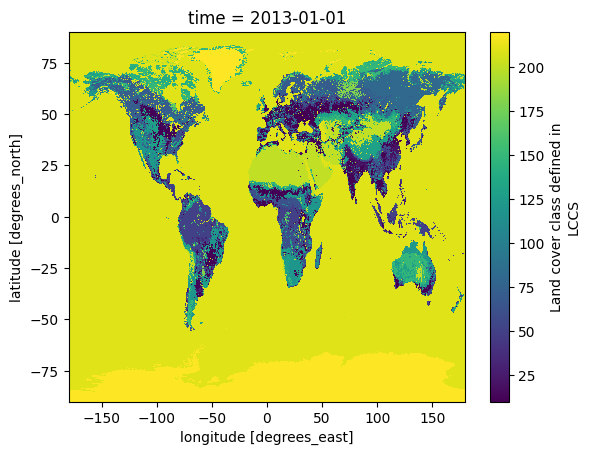

In [178]:
xr.open_zarr("landcover180.zarr").lccs_class[0,:,:].plot()

In [177]:
xr.open_zarr("landcover180.zarr").lccs_class[0,:,:].mean().compute()

<xarray.DataArray 'lccs_class' ()>
array(186.80777, dtype=float32)
Coordinates:
    time     datetime64[ns] 2013-01-01

In [22]:
xr.open_zarr("landcover360.zarr").lccs_class[0,:,:].mean().compute()

<xarray.DataArray 'lccs_class' ()>
array(186.81323, dtype=float32)
Coordinates:
    time     datetime64[ns] 2013-01-01

## canopy height (hc)

In [167]:
hc = xr.open_dataset('/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/canopy_height/canopy_height_11kmGlobal20240215.tif').band_data
hc = hc.squeeze('band')  # drop band dimension
hc = hc.rio.write_crs('WGS84')
hc = hc.rename(
    x='longitude',
    y='latitude',
)
hc = hc.sortby(["longitude", "latitude"])

In [168]:
hc

<xarray.DataArray 'band_data' (latitude: 1480, longitude: 3600)>
[5328000 values with dtype=float32]
Coordinates:
    band         int64 1
  * longitude    (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * latitude     (latitude) float64 -59.95 -59.85 -59.75 ... 87.75 87.85 87.95
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1

In [169]:
import numpy as np
hc.rio.write_nodata(np.nan, inplace=True)
hc = hc.rio.write_crs('EPSG:4326')
target = target.rio.write_crs('EPSG:4326')
hc_reprojected = hc.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
hc_reprojected = hc_reprojected.assign_coords({
    "x": hc_reprojected.x,
    "y": hc_reprojected.y,
})
# fix naming of coordinates
hc_reprojected = hc_reprojected.rename(
    x='longitude',
    y='latitude'
)
print(hc_reprojected)

<xarray.DataArray 'band_data' (latitude: 1801, longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      b1
    _FillValue:     nan


In [170]:
hc_reprojected = hc_reprojected.to_dataset(name='hc')

In [ ]:
hc_reprojected = hc_reprojected.chunk(
    longitude=250, 
    latitude=250
)
hc_reprojected.to_zarr(OUT_PATH, mode='w')

## Vcmax

In [136]:
vcmax = xr.open_dataset("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/Vcmax/TROPOMI_Vmax_Tg_mean.tif").band_data

In [146]:
vcmax.rio.write_crs("EPSG:4326", inplace=True)
vcmax.rio.write_nodata(np.nan, inplace=True)

<xarray.DataArray 'band_data' (band: 1, y: 360, x: 720)>
[259200 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        185.50468444824
    STATISTICS_MEAN:           32.584587871174
    STATISTICS_MINIMUM:        0.44747722148895
    STATISTICS_STDDEV:         30.55013573823
    STATISTICS_VALID_PERCENT:  20.61
    _FillValue:                nan

In [147]:
vcmax_fillna = vcmax.rio.interpolate_na(method='nearest') #interpolation method see: scipy.interpolate.griddata

In [148]:
vcmax_fillna = vcmax_fillna.rio.write_crs('WGS84')
vcmax_fillna = vcmax_fillna.rename(
    x='longitude',
    y='latitude',
)

In [150]:
vcmax_fillna_reprojected = vcmax_fillna.rio.reproject_match(target, resampling=Resampling.average, nodata=np.nan)
vcmax_fillna_reprojected = vcmax_fillna_reprojected.assign_coords({
    "x": vcmax_fillna_reprojected.x,
    "y": vcmax_fillna_reprojected.y,
})
# fix naming of coordinates
vcmax_fillna_reprojected = vcmax_fillna_reprojected.rename(
    x='longitude',
    y='latitude'
)
print(vcmax_fillna_reprojected)

<xarray.DataArray 'band_data' (band: 1, latitude: 1801, longitude: 3600)>
array([[[ 3.816184  ,  2.3694365 ,  2.3694365 , ...,  0.76924044,
          0.76924044,  0.76924044],
        [ 3.816184  ,  2.3694365 ,  2.3694365 , ...,  0.76924044,
          0.76924044,  0.76924044],
        [ 3.816184  ,  2.3694365 ,  2.3694365 , ...,  0.76924044,
          0.76924044,  0.76924044],
        ...,
        [ 4.095072  ,  1.6122515 ,  1.6122515 , ..., 12.563364  ,
         12.563364  , 12.563364  ],
        [ 4.095072  ,  1.6122515 ,  1.6122515 , ..., 12.563364  ,
         12.563364  , 12.563364  ],
        [ 4.095072  ,  1.6122515 ,  1.6122515 , ..., 12.563364  ,
         12.563364  , 12.563364  ]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude     (latitude) float32 -90.0 -89.9 -89.8 -89.7 ... 89.8 89.9 90.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STA

In [153]:
vcmax_fillna_reprojected = xr.where(target.notnull(), vcmax_fillna_reprojected, np.nan)

In [154]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected.where(vcmax_fillna_reprojected['latitude'] > -63, other=float('nan'))

In [155]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.to_dataset(name='vcmax')

In [ ]:
vcmax_fillna_reprojected_mask = vcmax_fillna_reprojected_mask.chunk(
    longitude=250, 
    latitude=250
)
vcmax_fillna_reprojected_mask.to_zarr(OUT_PATH, mode='w')

## Variable derivation

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client, LocalCluster
from PyStemmusScope import variable_conversion as vc
from dask_ml.preprocessing import OneHotEncoder

In [3]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah/"
data_paths = {"all_data": f"{parent_in_path}/all_data_{start_time}_{end_time}.zarr",
    "igbp_table": f"{parent_in_path}/lccs_to_igbp_table.csv",
    "igbp_class": f"{parent_in_path}/IGBP11unique.csv",
            }

parent_out_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah/"

chunks = {"time": 100, "longitude": 100, "latitude": 100}

In [4]:
# era5_land variables
all_data = xr.open_zarr(data_paths["all_data"])
all_data = all_data.chunk(chunks)

In [5]:
def era5land_accumulated_vars(ds, input_name, output_name, scale_factor):    
    input_da = ds[input_name] / scale_factor
    output_da = input_da.diff("time")
    output_da[0::24] = input_da[1::24]  # accumulation starts at t01 instead of t00
    
    t00 = xr.DataArray(np.nan, coords=input_da.isel(time=0).coords) # assign first t00 to none
    output_da = xr.concat([output_da, t00], dim='time')    
    ds[output_name] = output_da
    
    return ds

### variable calculations

In [6]:
all_data = era5land_accumulated_vars(all_data, "ssrd", "Rin", 3600)
all_data = era5land_accumulated_vars(all_data, "strd", "Rli", 3600)
all_data = era5land_accumulated_vars(all_data, "tp", "Precip_msr", 0.001) # to mm
all_data["p"] = all_data["sp"] / 100  # Pa -> hPa
all_data["Ta"] = all_data["t2m"] - 273.15  # K -> degC
all_data["ea"] = vc.calculate_es(all_data["d2m"] - 273.15)*10 # *10 is for kPa -> hPa
all_data["u"] = (all_data["u10"] ** 2 + all_data["v10"] ** 2) ** 0.5
all_data["ssm"] = all_data["ssm"] / 1000

### convert landcover to IGBP

In [122]:
from dask_ml.preprocessing import OneHotEncoder
# lookup tables
igbp_table = pd.read_csv(data_paths["igbp_table"])
igbp_class = pd.read_csv(data_paths["igbp_class"])['0'].unique()

# define one hot encoding for IGBP using dask-ml functions
encoder = OneHotEncoder(sparse_output=False)

# Unsorted categories are not yet supported by dask-ml
igbp_stemmus_scope = np.sort(igbp_table["IGBP_STEMMUS_SCOPE"].to_numpy().reshape(-1,1))

encoder = encoder.fit(igbp_stemmus_scope)  
        
lookup_table = igbp_table.set_index("lccs_class").T.to_dict('records')[0]

def map_landcover_to_igbp(landcover_block):
    # Create a new DataArray with "no data" to hold the mapped values 
    mapped_block = da.full_like(landcover_block, fill_value="No data", dtype="U7")

    # For each key-value pair in the lookup table
    for key, value in lookup_table.items():
        # Where the landcover_block equals the current key, assign the corresponding value
        mapped_block = da.where(landcover_block == key, value, mapped_block)
    
    return mapped_block
        

def landcover_to_igbp(ds, landcover_var_name, encoder):
    landcover = ds[landcover_var_name][0,:,:]
    
    # Replace NaN values with "No data" or 255 in the table
    landcover = da.where(da.isnan(landcover), 255, landcover)
    
    igbp = map_landcover_to_igbp(landcover)
    igbp_reshaped = igbp.reshape(-1, 1)

    transformed = encoder.transform(igbp_reshaped)
    
    # Select the columns that correspond to the categories in igbp_class
    indices = [np.where(encoder.categories_[0] == category)[0][0] for category in igbp_class]    
#     transformed = transformed[:, indices]

#     # Add each column of the transformed array as a new variable in the dataset
#     for i in range(transformed.shape[1]):
#         ds[f"IGBP_veg_long{i+1}"] = (("latitude", "longitude"), transformed[:, i].reshape(igbp.shape))

    return transformed

In [119]:
map_landcover_to_igbp(all_data['landcover'][0,:]).reshape(-1, 1)[110,].compute()

array(['Water bodies'], dtype='<U28')

In [123]:
ds = landcover_to_igbp(all_data, "landcover", encoder)
# ds = ds.chunk(chunks)

In [102]:
ds[110,:].compute()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [66]:
1294440/323610

4.0

In [96]:
from sklearn.preprocessing import OneHotEncoder
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    print(IGBP.shape)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[0]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

In [98]:
landcover_to_igbp(all_data['landcover'][0,:,:], igbp_table, igbp_class).mean().mean()

(469, 690)


/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


0.044102188099592377

In [91]:
landcover = all_data['landcover'][0,:,:]

# Replace NaN values with "No data" or 255 in the table
landcover = da.where(da.isnan(landcover), 255, landcover)

igbp = map_landcover_to_igbp(landcover)

In [195]:
# svae to zarr
out_path = f"{parent_out_path}/model_input_{start_time}_{end_time}.zarr"
encoding = {var: {'chunks': (100, 100, 100)} for var in ds.data_vars}
ds.to_zarr(out_path, mode='w', encoding=encoding)
print(f"{out_path} is saved")

/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah//model_input_2014-1-31_2014-02-10.zarr is saved


## Model prediction

In [199]:
import pickle
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from dask.distributed import Client, LocalCluster

In [200]:
start_time = "2014-1-31"
end_time = "2014-02-10"

parent_in_path1 = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/3RF_train/"
parent_in_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah/"
parent_out_path = "/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah/"

chunks = {"time": 100, "longitude": 100, "latitude": 100}

In [201]:
# load model
path_model = f"{parent_in_path1}/hourly_multi7_depth20_min1219.pkl"
with open(path_model, 'rb') as f:
    model = pickle.load(f)
model

MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10,
                                                     n_estimators=10, n_jobs=1,
                                                     random_state=0))

In [202]:
# rename some variables
model_input = xr.open_zarr(f"{parent_in_path}/model_input_{start_time}_{end_time}.zarr")
model_input = model_input.chunk(chunks)

rename_vars = {"co2": "CO2", "lai": "LAI", "canopyheight": "hc", "ssm": "SSM", "vcmax": "Vcmo"}
ds = model_input.rename(rename_vars)

input_vars = [
    'Rin', 'Rli', 'p', 'Ta', 'ea', 'u', 'CO2', 'LAI', 'Vcmo','hc', 'Precip_msr',  
    'SSM',  *[f'IGBP_veg_long{i}' for i in range(1, 12)]
]

# select input data 
input_ds = ds[input_vars]

# define output template
output_vars = ['LEtot','Htot','Rntot','Gtot', 'Actot','SIF685', 'SIF740']
output_temp = xr.Dataset()
ds_shape = (input_ds.sizes['time'], input_ds.sizes['latitude'], input_ds.sizes['longitude'])

for var in output_vars:
    output_temp[var] = xr.DataArray(
        name = var,
        data=da.zeros(ds_shape),
        dims=input_ds.dims,
        coords=input_ds.coords,
    )
output_temp = output_temp.chunk(chunks) # the same chunk as input

In [203]:
def predictFlux(input_ds, model, output_vars):

    df_features = input_ds.to_dataframe().reset_index().drop(columns=["time", "longitude", "latitude"])
    
    # Convert the nan value as 0 for the calculation
    df_features = df_features.fillna(0)
    
    LEH = model.predict(df_features)
    
    output_ds = xr.Dataset(coords=input_ds.coords)
    ds_shape = (output_ds.sizes['time'], output_ds.sizes['latitude'], output_ds.sizes['longitude'])
    
    for i, name in enumerate(output_vars):
        output_ds[name] = (("time", "latitude", "longitude"), LEH[:, i].reshape(ds_shape))
    
    return output_ds

In [204]:
# result
LEH = xr.map_blocks(
    predictFlux,
    input_ds,
    kwargs={
        "model": model, 
        "output_vars": output_vars, 
    },
    template=output_temp,
)
LEH = LEH.chunk(chunks)

# mask nan values
LEH_masked = LEH.where(input_ds["Rin"].notnull())

In [205]:
# svae to zarr
out_path = f"{parent_out_path}/predicted_{start_time}_{end_time}.zarr"
encoding = {var: {'chunks': (100, 100, 100)} for var in LEH_masked.data_vars}
LEH_masked.to_zarr(out_path, mode='w', encoding=encoding)
print(f"{out_path} is saved")

/gpfs/work2/0/ttse0619/qianqian/global_data_Qianqian/testSarah//predicted_2014-1-31_2014-02-10.zarr is saved


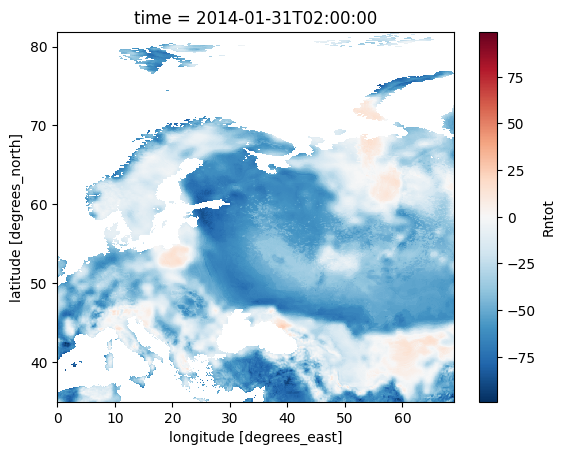

In [206]:
LEH_masked.Rntot.isel(time=2).plot()

In [209]:
LEH_masked

<xarray.Dataset>
Dimensions:    (time: 264, latitude: 469, longitude: 690)
Coordinates:
  * latitude   (latitude) float64 35.0 35.1 35.2 35.3 ... 81.5 81.6 81.7 81.8
  * longitude  (longitude) float64 0.0 0.1 0.2 0.3 0.4 ... 68.6 68.7 68.8 68.9
  * time       (time) datetime64[ns] 2014-01-31 ... 2014-02-10T23:00:00
Data variables:
    LEtot      (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Htot       (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Rntot      (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Gtot       (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    Actot      (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    SIF685     (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>
    SIF740     (time, latitude, longitude) float64 dask.array<chunksize=(100, 100, 100), meta=np.ndarray>

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


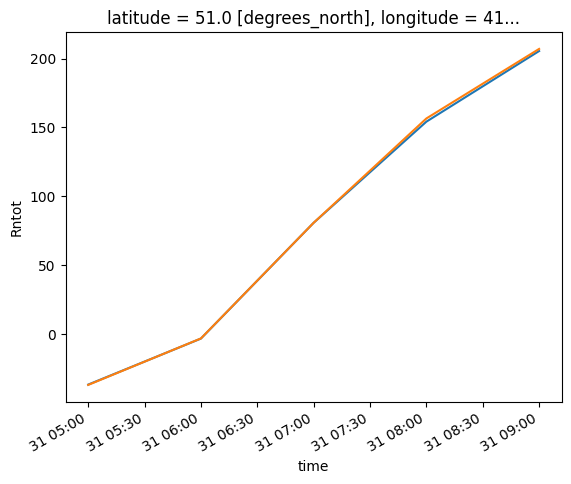

In [243]:
LEH_masked.Rntot.sel(latitude=(51),longitude=(41))[5:10].plot() # unit is W/m2
qq.Rntot.sel(latitude=(51),longitude=(41))[5:10].plot() # unit is W/m2

In [211]:
qq = xr.open_zarr("/projects/0/ttse0619/qianqian/global_data_Qianqian/1input_data/2014EmulatorShowcaseSarah/Europe0_fluxes_RFSS_2014_v1.1.zarr")

In [237]:
qq.sel(
    latitude=slice(81.85192337, 34.93055094), 
    longitude=slice(0, 20),  
).Rntot[-25,:,:].mean().compute(),LEH_masked.sel(
    latitude=slice(34.93055094, 81.85192337), 
    longitude=slice(0, 20),  
).Rntot[-25,:,:].mean().compute()

(<xarray.DataArray 'Rntot' ()>
 array(-40.59980746)
 Coordinates:
     time     datetime64[ns] 2014-02-09T23:00:00,
 <xarray.DataArray 'Rntot' ()>
 array(-40.75664888)
 Coordinates:
     time     datetime64[ns] 2014-02-09T23:00:00)

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


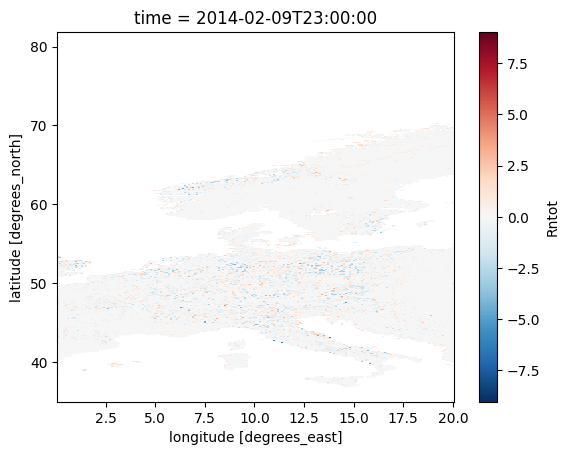

In [239]:
(qq.sel(
    latitude=slice(81.85192337, 34.93055094), 
    longitude=slice(0, 20),  
).Rntot[-25,:,:] - LEH_masked.sel(
    latitude=slice(34.93055094, 81.85192337), 
    longitude=slice(0, 20),  
).Rntot[-25,:,:] ).plot()

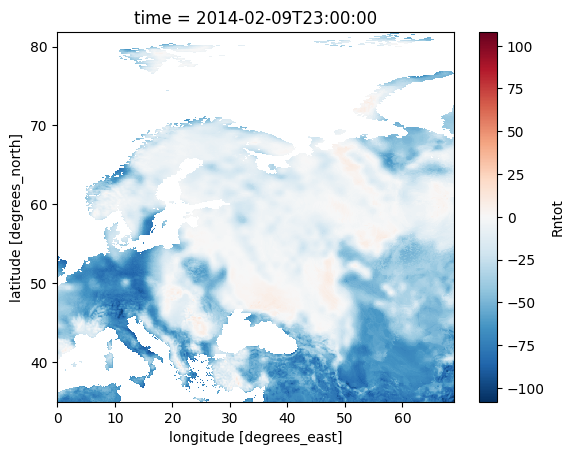

In [233]:
LEH_masked.Rntot[-25,:,:].

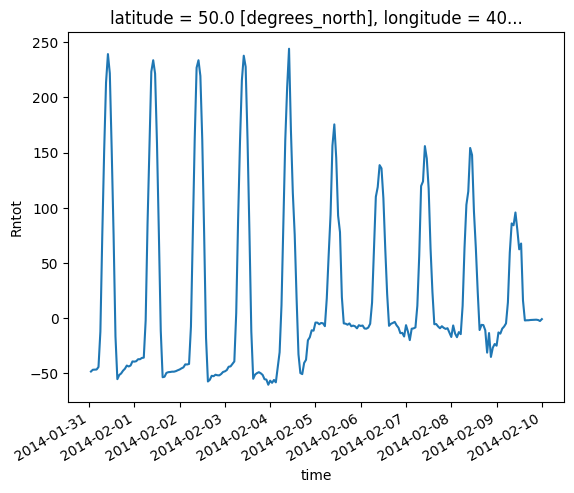